In [6]:
import csv
import os.path
import numpy as np
from keras.models import Sequential, Model, Input
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers
from keras.layers import *
from keras.layers.normalization import BatchNormalization

from rbflayer import RBFLayer, InitCentersRandom
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import math
import pandas as pd

This dataset summarizes a heterogeneous set of features about articles published by Mashable in a period of two years.
The goal is to predict the number of shares in social networks (popularity).<br>
<br>
Reference material <br>
https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/2799933550853697/3155681567642906/2202577924924539/latest.html<br>
http://benalexkeen.com/feature-scaling-with-scikit-learn/ <br>
https://github.com/PetraVidnerova/rbf_keras/blob/master/rbflayer.py <br>
https://archive.ics.uci.edu/ml/datasets/online+news+popularity <br><br>
Target is element 60, shares:     Number of shares
<br>
Omitted url, timedelta, LDA, is_weekend, kw_min_min, kw_avg_min, kw_min_avg<br>
Convert following binary data to categorical data, weekday, data_channel

In [7]:
# loading of dataset 
dataset = []
labels = []
headers = []

def load_dataset_raw():
    global dataset, labels, headers
    with open('OnlineNewsPopularity.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        headers = next(reader) # the first row
        headers = headers[1:]
        headers = [x.strip(' ') for x in headers]    
            
        temp_data = []
        temp_label = []
        for idx, row in enumerate(reader):
            temp_data.append(row[1:])
            temp_label.append(row[-1])

        # convert elements to float        
        for idx, row in enumerate(temp_data):        
            dataset.append([float(i) for i in row[:]])
        for idx, row in enumerate(temp_label):
            labels.append(float(row))   
        
    return np.array(dataset), np.array(labels).reshape(-1, 1)

def load_dataset(is_normalize=True, is_remove_outlier=True, select_top=50):
    """
    is_normalize: To normalize or keep orignal form
    is_remove_outlier: To remove outlier 
    select_top: select top important features using PCA (Principal component analysis)
    """
    global dataset, labels, headers
    dataset, labels = load_dataset_raw()
    print('Original dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))
    
    fields_to_avoid = [0, 18, 20, 24, 38, 39, 40, 41, 42]
    weekday = [30, 31, 32, 33, 34, 35, 36, 37]
    data_channel = [12, 13, 14, 15, 16, 17]
    fields_to_avoid = fields_to_avoid + weekday + data_channel
    fields_to_avoid = sorted(fields_to_avoid)

    # adjust headers
    sub_headers = []
    for idx, h in enumerate(headers):
        if idx not in fields_to_avoid:
            sub_headers.append(h)
    sub_headers.insert(len(sub_headers) - 1, 'weekday')
    sub_headers.insert(len(sub_headers) - 1, 'data_channel')
    headers = sub_headers
    
    # filter columns and categorical fields
    new_dataset = []        
    for idx, row in enumerate(dataset):
        slice_row = [i for num,i in enumerate(row) if num not in fields_to_avoid]
        insert_idx = len(slice_row) - 1

        for col_idx in range(len(row)):
            # convert week day to categorical 
            if col_idx in weekday and row[col_idx] == 1:
                if col_idx == 30:
                    slice_row.insert(insert_idx, 1)
                elif col_idx == 31:
                    slice_row.insert(insert_idx, 2)
                elif col_idx == 32:
                    slice_row.insert(insert_idx, 3)
                elif col_idx == 33:
                    slice_row.insert(insert_idx, 4)
                elif col_idx == 34:
                    slice_row.insert(insert_idx, 5)
                elif col_idx == 35:
                    slice_row.insert(insert_idx, 6)
                elif col_idx == 36:
                    slice_row.insert(insert_idx, 7)

            # convert data channel to categorical 
            if col_idx in data_channel and row[col_idx] == 1:
                if col_idx == 12:
                    slice_row.insert(insert_idx, 1)
                elif col_idx == 13:
                    slice_row.insert(insert_idx, 2)
                elif col_idx == 14:
                    slice_row.insert(insert_idx, 3)
                elif col_idx == 15:
                    slice_row.insert(insert_idx, 4)
                elif col_idx == 16:
                    slice_row.insert(insert_idx, 5)
                elif col_idx == 17:
                    slice_row.insert(insert_idx, 6)

        # handle missing data
        if len(slice_row) == 38:
            slice_row.append(0)
        new_dataset.append(slice_row)         
    
    # copy filter new_dataset to dataset 
    dataset = new_dataset
    
    # normalizing in dataset
    if is_normalize:
        # it is important which type of normalization method you use
        scaler = preprocessing.MinMaxScaler()
        dataset = scaler.fit_transform(dataset)
        # last item uses MinMaxScaler
        labels = np.array(labels).reshape(-1, 1)
        scaler = preprocessing.QuantileTransformer()
        labels = scaler.fit_transform(labels)
        print('Data is normalize')
    else:
        print('No normalize apply')        

    # remove outlier in dataset
    if is_remove_outlier:
        dataset, labels = reject_outliers(dataset, labels)    

    # applying PCA in dataset
    if 0 < select_top < len(dataset[0]):
        top_features = pca_important_features(dataset, headers, top=select_top)
        feature_keys = [f[1] for f in top_features]
        df = pd.DataFrame(dataset, columns=headers)
        top_dataset = []
        for name in feature_keys:
            top_dataset.append(df.loc[:, name])
        dataset = np.transpose(top_dataset)
        
    return np.array(dataset), np.array(labels).reshape(-1, 1)

def pca_important_features(dataset, headers, top=10):
    scaleFeatures = True
    pca = PCA(n_components=top)
    projected  = pca.fit_transform(dataset)
    top_features = extract_features(projected, pca.components_, headers, top)
    return top_features
    
def extract_features(transformed_features, components_, columns, top):
    num_columns = len(columns)

    # This funtion will project your *original* feature (columns)
    # onto your principal component feature-space, so that you can
    # visualize how "important" each one was in the
    # multi-dimensional scaling

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print("Features by top {0} importance:".format(top))
    for feature in important_features[:top]:
        print(feature)
    print()
    return important_features[:top]
        
def reject_outliers(dataset, labels, m=50):        
    """
    Higher the value 'm' more outliers
    """
    d = np.abs(labels - np.median(labels))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
        
    # remove outliers in dataset and labels
    sub_dataset = []
    sub_labels = []
    outlier_labels = []
    for idx, item in enumerate(s):        
        if item < m:
            sub_labels.append(labels[idx])
            sub_dataset.append(dataset[idx])        
        else:
            outlier_labels.append(labels[idx])
    print('Outlier removed: {0}'.format(len(outlier_labels)))
    return sub_dataset, sub_labels

In [8]:
# Splitting of dataset into train and test
dataset = []
labels = []
dataset, labels = load_dataset(is_normalize=True, is_remove_outlier=True, select_top=-1)
print('Dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))

x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, shuffle=False, random_state=42)
print("x_train: {0}, y_train: {1}".format(x_train.shape, y_train.shape))
print("x_test: {0}, y_test: {1}".format(x_test.shape, y_test.shape))

# print(dataset[0])
# print(labels[:-10])

Original dataset shape: (39644, 60), Labels: (39644, 1)
Data is normalize
Outlier removed: 0
Dataset shape: (39644, 39), Labels: (39644, 1)
x_train: (31715, 39), y_train: (31715, 1)
x_test: (7929, 39), y_test: (7929, 1)


dataset (39644, 39)
labels (39644, 1)
Labels max value: 0.9999999000000003
Labels min value: 9.999999977795539e-08
Labels avg value: 0.5000743959674698


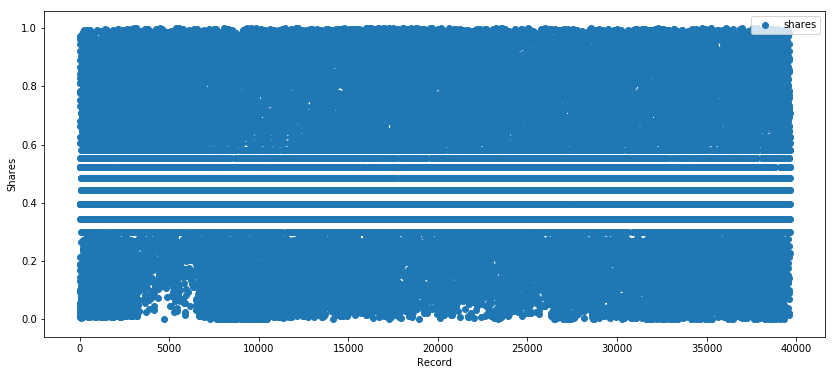

In [9]:
# Quick view of processed datasets
print('dataset {0}'.format(dataset.shape))
print('labels {0}'.format(labels.shape))
print('Labels max value: {0}'.format(np.max(labels)))
print('Labels min value: {0}'.format(np.min(labels)))
print('Labels avg value: {0}'.format(np.average(labels)))

def show_graph(data):
    plt.figure(figsize=(14,6))
    plt.xlabel("Record")
    plt.ylabel("Shares")
    plt.title("")
    x = list(range(len(data)))
    plt.scatter(x, [pt[0] for pt in data], label='shares')
    plt.legend(loc='upper right')
    plt.show()

def show_histogram(data):
    plt.figure(figsize=(14,6))
    plt.hist(data, 100)
    plt.show()

show_graph(labels)
# show_histogram(labels)

In [10]:
# build models for ensemble
# Multi layer perceptron
l2_kernal = 0.0001

model_mlp = Sequential()
model_mlp.add(Dense(512, input_dim=39, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(1, activation='sigmoid', activity_regularizer=regularizers.l2(l2_kernal)))

model_mlp.compile(loss='mean_squared_error',
              optimizer=RMSprop(lr=0.001),
              metrics=['mse'])

# Radial basis function model
model_rbf = Sequential()
model_rbf = Sequential()
model_rbf.add(Dense(128, input_dim=39, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model_rbf.add(Dropout(0.5))
model_rbf.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model_rbf.add(Dropout(0.5))
rbflayer = RBFLayer(20,
                    betas=0.1,
                    input_shape=(20,))
model_rbf.add(rbflayer)
model_rbf.add(Dense(1, activation='sigmoid'))

model_rbf.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.001),
              metrics=['mse'])

# load weights for both models
saved_weights_mlp = 'best_weights_mlp.h5'
saved_weights_rbf = 'best_weights_rbf.h5'

# load weights if any
if os.path.isfile(saved_weights_mlp):
    model_mlp.load_weights(saved_weights_mlp)
    print("MLP weights loaded: {0}".format(saved_weights_mlp))

if os.path.isfile(saved_weights_rbf):
    model_rbf.load_weights(saved_weights_rbf)
    print("RBF weights loaded: {0}".format(saved_weights_rbf))    
print()

print('Multi layer perceptron')
model_mlp.summary()
print()
print()
print('Radial basis function')
model_rbf.summary()

models = [model_mlp, model_rbf]

MLP weights loaded: best_weights_mlp.h5
RBF weights loaded: best_weights_rbf.h5

Multi layer perceptron
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               20480     
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
______________________________________

### Creating ensemble model using averaging

In [11]:
def ensemble(models, model_input):
    yModels=[model(model_input) for model in models] 
    yAvg=Average()(yModels)
    modelEns = Model(inputs=model_input, outputs=yAvg, name='ensemble')
    return modelEns

model_input = Input(shape=x_train[0].shape)
ensemble_model = ensemble(models, model_input)
ensemble_model.compile(loss='mean_squared_error',
         optimizer=RMSprop(lr=0.0001),
         metrics=['mse'])

ensemble_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 39)           0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 1)            250625      input_1[0][0]                    
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 1)            8141        input_1[0][0]                    
__________________________________________________________________________________________________
average_1 (Average)             (None, 1)            0           sequential_4[1][0]               
                                                                 sequential_6[1][0]               
Total para

**Ensemble Average** <br>
MLP model = 50% <br>
RBF model = 50% <br>

7929/7929 [==============================] - 1s 65us/step
actual max 0.9992343966165429
actual min 6.387735547748322e-05
actual median 0.4444444444444444
predict max 0.9999999403953552
predict min 0.23523321747779846
predict median 0.3920243978500366

loss: 0.029593
mean_squared_error: 0.010654
root_mse: 0.103218
explained_variance_score: 0.817691
mean_absolute_error: 0.080815
mean_squared_log_error: 0.00657
median_absolute_error: 0.06289
r2_score: 0.815295


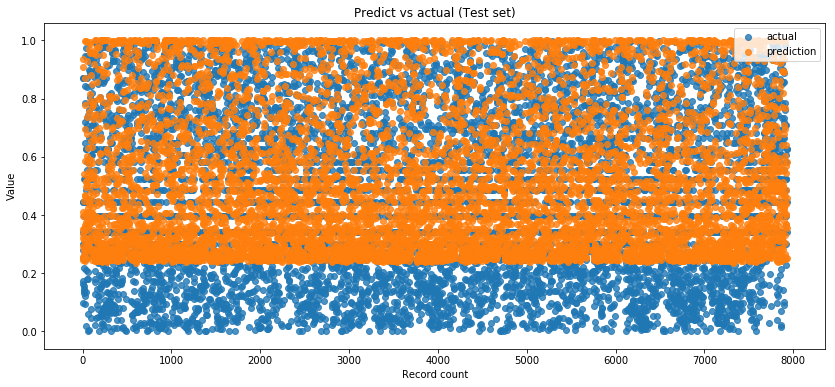

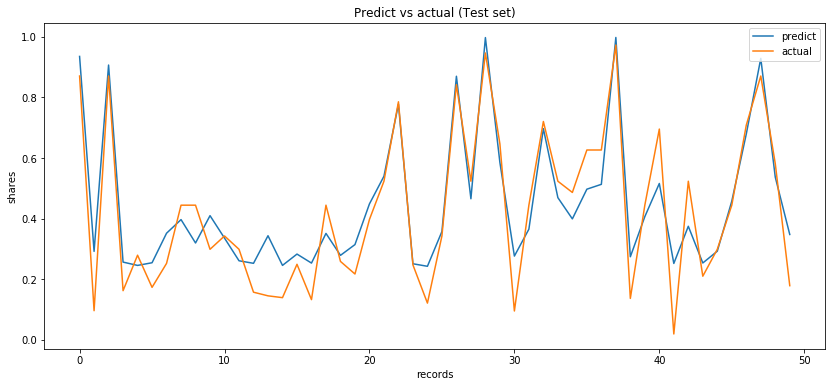

In [12]:
# showing results
scores = ensemble_model.evaluate(x_test, y_test)

# http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
y_pred = ensemble_model.predict(x_test)

root_mse = math.sqrt(scores[1])
var_score = explained_variance_score(y_pred, y_test)
mean_abs_error = mean_absolute_error(y_pred, y_test)
mean_sqare_log_error = mean_squared_log_error(y_pred, y_test)
median_abs_error = median_absolute_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

print('actual max {0}'.format(np.max(y_test)))
print('actual min {0}'.format(np.min(y_test)))
print('actual median {0}'.format(np.median(y_test)))
print('predict max {0}'.format(np.max(y_pred)))
print('predict min {0}'.format(np.min(y_pred)))
print('predict median {0}'.format(np.median(y_pred)))
print()
print("{0}: {1}".format(ensemble_model.metrics_names[0], round(scores[0], 6)))
print("{0}: {1}".format(ensemble_model.metrics_names[1], round(scores[1], 6)))
print('root_mse: {0}'.format(round(root_mse, 6)))
print('explained_variance_score: {0}'.format(round(var_score, 6)))
print('mean_absolute_error: {0}'.format(round(mean_abs_error, 6)))
print('mean_squared_log_error: {0}'.format(round(mean_sqare_log_error, 6)))
print('median_absolute_error: {0}'.format(round(median_abs_error, 6)))
print('r2_score: {0}'.format(round(r2, 6)))

# plt.figure(figsize=(14,6))
# plt.hist(y_pred, 100)
# plt.hist(y_test, 100)
# plt.show()

# plt.figure(figsize=(14,6))
# plt.plot(history.history['mean_squared_error'])
# plt.plot(history.history['val_mean_squared_error'])
# plt.title('Train vs validation loss')
# plt.ylabel('mse')
# plt.xlabel('epochs')
# plt.legend(['mse', 'val_mse'], loc='upper right')
# plt.show()

plt.figure(figsize=(14,6))
plt.xlabel("Record count")
plt.ylabel("Value")
plt.title("Predict vs actual (Test set)")
x = list(range(len(y_pred)))
# plt.ylim(0, 1)
plt.scatter(x, [pt[0] for pt in y_test], label='actual', alpha=0.8)
plt.scatter(x, [pt[0] for pt in y_pred], label='prediction', alpha=0.8)
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(14,6))
plt.title('Predict vs actual (Test set)')
plt.plot(y_pred[:50])
plt.plot(y_test[:50])
plt.ylabel('shares')
plt.xlabel('records')
plt.legend(['predict', 'actual'], loc='upper right', borderaxespad=0.5)
plt.show()

**Ensemble weighted average** <br>
MLP model = 80% <br>
RBF model = 20% <br>

mean_sqr_error: 0.00989
root_mse: 0.09945
explained_variance_score: 0.836669
mean_absolute_error: 0.075827
mean_squared_log_error: 0.006131
median_absolute_error: 0.055935
r2_score: 0.832654


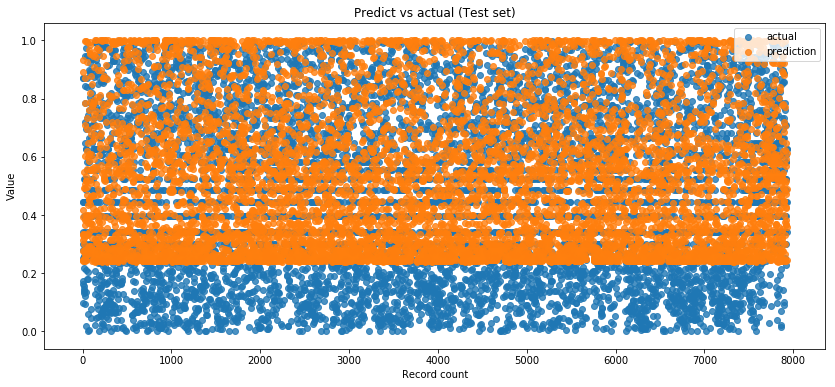

In [13]:
# models = [model_mlp, model_rbf]
def ensemble_weighted_avg(models):
    y_pred1 = models[0].predict(x_test)
    y_pred2 = models[1].predict(x_test)
    # weighted_avg
    weighted_avg = []
    for idx in range(len(y_pred1)):
        weighted_avg.append(y_pred1[idx][0] * 0.8 + y_pred2[idx][0] * 0.2)
    return weighted_avg

y_pred = ensemble_weighted_avg(models)
# y_pred = models[0].predict(x_test)
y_pred = np.array(y_pred)
y_pred = y_pred.reshape(len(y_pred), 1)

mean_sqr_error = mean_squared_error(y_pred, y_test)
root_mse = math.sqrt(mean_sqr_error)
var_score = explained_variance_score(y_pred, y_test)
mean_abs_error = mean_absolute_error(y_pred, y_test)
mean_sqare_log_error = mean_squared_log_error(y_pred, y_test)
median_abs_error = median_absolute_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

print('mean_sqr_error: {0}'.format(round(mean_sqr_error, 6)))
print('root_mse: {0}'.format(round(root_mse, 6)))
print('explained_variance_score: {0}'.format(round(var_score, 6)))
print('mean_absolute_error: {0}'.format(round(mean_abs_error, 6)))
print('mean_squared_log_error: {0}'.format(round(mean_sqare_log_error, 6)))
print('median_absolute_error: {0}'.format(round(median_abs_error, 6)))
print('r2_score: {0}'.format(round(r2, 6)))

plt.figure(figsize=(14,6))
plt.xlabel("Record count")
plt.ylabel("Value")
plt.title("Predict vs actual (Test set)")
x = list(range(len(y_pred)))
# plt.ylim(0, 1)
plt.scatter(x, [pt[0] for pt in y_test], label='actual', alpha=0.8)
plt.scatter(x, [pt[0] for pt in y_pred], label='prediction', alpha=0.8)
plt.legend(loc='upper right')
plt.show()